# EQWorks challenge

We first read-off the files from Github repository. We will use the raw data. The DataSample.csv file contains 22015 rows while POIList.csv only 4.

In [1]:
import pandas as pd

In [2]:
url1 = "https://raw.githubusercontent.com/EQWorks/ws-data-spark/master/data/DataSample.csv"

df_DataSample = pd.read_csv(url1, parse_dates = True)

In [3]:
df_DataSample.head(10)

,_ID,TimeSt,Country,Province,City,Latitude,Longitude
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730
5,4516693,2017-06-21 14:00:00.597,CA,ON,Kitchener,43.43810,-80.50990
6,4516771,2017-06-21 10:00:00.873,CA,ON,Sarnia,42.96100,-82.37300
7,4516831,2017-06-21 12:00:00.950,CA,ON,London,43.00910,-81.17650
8,4516915,2017-06-21 15:00:01.310,CA,ON,London,43.00910,-81.17650
9,4516953,2017-06-21 16:00:01.700,CA,ON,Kitchener,43.42780,-80.51350


In [4]:
len(df_DataSample.index)

22025

In [5]:
url2 = "https://raw.githubusercontent.com/EQWorks/ws-data-spark/master/data/POIList.csv"

df_POIList = pd.read_csv(url2, parse_dates = True)

In [6]:
df_POIList.head()

,POIID,Latitude,Longitude
0,POI1,53.546167,-113.485734
1,POI2,53.546167,-113.485734
2,POI3,45.521629,-73.566024
3,POI4,45.224830,-63.232729


## Part 0: Cleaning 

Let's first look at the duplicated rows that have have identical geoinfo and timest entries; these rows are deemed suspicious. Analysis shows that there are 2026 such rows.

In [7]:
df_DataSample.columns

Index(['_ID', ' TimeSt', 'Country', 'Province', 'City', 'Latitude',
       'Longitude'],
      dtype='object')

In [8]:
df_DataSample[df_DataSample.duplicated(subset=[' TimeSt','Latitude', 'Longitude'], keep='first')].\
head(10)

,_ID,TimeSt,Country,Province,City,Latitude,Longitude
12,4517047,2017-06-21 12:00:00.950,CA,ON,London,43.00910,-81.17650
19,4517347,2017-06-21 03:00:00.287,CA,ON,Windsor,42.29570,-82.95990
37,4518179,2017-06-21 08:00:00.663,CA,ON,Kitchener,43.46760,-80.48470
56,4519066,2017-06-21 07:00:00.747,CA,ON,Tillsonburg,42.86185,-80.72991
77,4520202,2017-06-21 17:00:02.433,CA,ON,Windsor,42.26540,-83.02610
83,4520494,2017-06-21 22:00:03.637,CA,ON,Windsor,42.26540,-83.02610
94,4521232,2017-06-21 18:00:06.077,CA,ON,Windsor,42.25450,-82.98090
111,4522138,2017-06-21 14:00:03.750,CA,ON,Guelph,43.57760,-80.22010
141,4523685,2017-06-21 20:00:04.430,CA,ON,London,43.00610,-81.29620
177,4525348,2017-06-21 01:00:07.037,CA,ON,Kitchener,43.46310,-80.44930


In [9]:
len(df_DataSample[df_DataSample.duplicated(subset=[' TimeSt','Latitude', 'Longitude'], 
                                           keep='first')].index)

2026

We then for convenience remove spaces and underscores from the names of the columns at the beginning of each name.

In [10]:
df_DataSample.rename(columns=lambda x: x.lstrip().lstrip('_'), inplace=True)

df_DataSample.columns

Index(['ID', 'TimeSt', 'Country', 'Province', 'City', 'Latitude', 'Longitude'], dtype='object')

Let's remove these duplicate rows inplace and reset index afterwards. We are now down to 19999 rows.

In [11]:
df_DataSample.drop_duplicates(subset=['TimeSt','Latitude', 'Longitude'], 
                                           keep='first', inplace = True)

df_DataSample.reset_index(drop = True, inplace = True)

In [12]:
len(df_DataSample.index)

19999

We also see that there are duplicate rows in the POIList.csv file. We remove one of the rows there as well. But before doing this we also remove space in the ' Latitude' name.

In [13]:
df_POIList.columns

Index(['POIID', ' Latitude', 'Longitude'], dtype='object')

In [14]:
df_POIList.rename(columns=lambda x: x.lstrip(), inplace=True)

df_POIList.columns

Index(['POIID', 'Latitude', 'Longitude'], dtype='object')

In [15]:
df_POIList.drop_duplicates(subset=['Latitude', 'Longitude'], 
                                           keep='first', inplace = True)

df_POIList.reset_index(drop = True, inplace = True)

In [16]:
df_POIList.head()

,POIID,Latitude,Longitude
0,POI1,53.546167,-113.485734
1,POI3,45.521629,-73.566024
2,POI4,45.224830,-63.232729


## Part 1: Label 

Let's assign each request to one of the POI locations that has a minimum distance to the request location. We will be using Pythagorean distance only for simplicity, which of course does not have much to do with reality. We in fact assume that we work on the plane map of the world. One should use Haversine or Vincenty distance and make plots on a sphere. 

In [17]:
import numpy as np

In [18]:
def euclidean2D(x1, x2, y1, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def euclfunc(df_DataSample):
    
    auxlist= []
    
    for i in list(df_POIList.index):
        auxlist.append(euclidean2D(df_DataSample.Latitude, df_POIList.Latitude[i],
                      df_DataSample.Longitude, df_POIList.Longitude[i]))
    
    k = np.argmin(auxlist)
    
    return df_POIList.POIID[k], auxlist[k]


In [19]:
df_DataSample['Nearest_POIID'], df_DataSample['Distance']\
        = zip(*df_DataSample.apply(euclfunc, axis = 1))

In [20]:
df_DataSample.head(10)

,ID,TimeSt,Country,Province,City,Latitude,Longitude,Nearest_POIID,Distance
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123,POI3,7.216087
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090,POI3,8.125912
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010,POI3,6.932242
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730,POI3,7.716841
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730,POI3,7.716841
5,4516693,2017-06-21 14:00:00.597,CA,ON,Kitchener,43.43810,-80.50990,POI3,7.249725
6,4516771,2017-06-21 10:00:00.873,CA,ON,Sarnia,42.96100,-82.37300,POI3,9.171676
7,4516831,2017-06-21 12:00:00.950,CA,ON,London,43.00910,-81.17650,POI3,8.014496
8,4516915,2017-06-21 15:00:01.310,CA,ON,London,43.00910,-81.17650,POI3,8.014496
9,4516953,2017-06-21 16:00:01.700,CA,ON,Kitchener,43.42780,-80.51350,POI3,7.256138


Let's print the maximum and minimum values of the longitude and latitude.

In [21]:
print('The maximum value of latitude is:', np.max(df_DataSample.Latitude))
print('The minimum value of latitude is:', np.min(df_DataSample.Latitude))
print('The maximum value of longitude is:', np.max(df_DataSample.Longitude))
print('The minimum value of longitude is:', np.min(df_DataSample.Longitude))

The maximum value of latitude is: 62.8273
The minimum value of latitude is: 6.92742
The maximum value of longitude is: 125.7022
The minimum value of longitude is: -136.53957


We see that there are some suspicious data that involve the positive longitudes. There are 22 such entries, and these data seem extreme and suspicious. Let's remove them. 

In [22]:
len(df_DataSample[df_DataSample.Longitude > 0])

22

In [23]:
df_DataSample = df_DataSample[df_DataSample.Longitude < 0]

df_DataSample.reset_index(drop = True, inplace = True)

Let's now print the maximal and minimal values of the latitude and longitude once again. Now, the data seem much more reasonable.

In [24]:
min_lat = np.min(df_DataSample.Latitude)
max_lat = np.max(df_DataSample.Latitude)
min_lon = np.min(df_DataSample.Longitude)
max_lon = np.max(df_DataSample.Longitude)

print('The maximum value of latitude is:', max_lat)
print('The minimum value of latitude is:', min_lat)
print('The maximum value of longitude is:', max_lon)
print('The minimum value of longitude is:', min_lon)

The maximum value of latitude is: 62.8273
The minimum value of latitude is: 42.054
The maximum value of longitude is: -52.6566
The minimum value of longitude is: -136.53957


## Part 2: Analysis

For each POI, we calculate the average and standard deviation of distances between a given POI location and each of its assigned requests. We also compute the radius (given by the maximum distance for a given POI) and density (request count/circle area) for each POI location. We create the corresponding four columns and add them to df_POIList dataframe. The map functions with dictionaries will be used for this purpose. The dictionaries dict1, dict2, dict3 and dict4 are for the mean, standard deviation, radius and density respectively.

In [25]:
dict1 = {df_POIList.POIID[k]: np.mean(df_DataSample.Distance[df_DataSample.Nearest_POIID == \
                            df_POIList.POIID[k]]) for k in list(df_POIList.index)}

dict2 = {df_POIList.POIID[k]: np.std(df_DataSample.Distance[df_DataSample.Nearest_POIID == \
                            df_POIList.POIID[k]]) for k in list(df_POIList.index)}

dict3 = {df_POIList.POIID[k]: np.max(df_DataSample.Distance[df_DataSample.Nearest_POIID == \
                            df_POIList.POIID[k]]) for k in list(df_POIList.index)}

dict4 = {df_POIList.POIID[k]: \
         len(df_DataSample.Distance[df_DataSample.Nearest_POIID == df_POIList.POIID[k]])/ \
         (np.pi* (np.max(df_DataSample.Distance[df_DataSample.Nearest_POIID == \
                            df_POIList.POIID[k]])**2))
         for k in list(df_POIList.index)}

In [26]:
df_POIList['Distance_Mean'] = df_POIList.POIID.map(dict1)
df_POIList['Distance_Std'] = df_POIList.POIID.map(dict2)
df_POIList['Radius'] = df_POIList.POIID.map(dict3)
df_POIList['Density'] = df_POIList.POIID.map(dict4)

In [27]:
df_POIList.head()

,POIID,Latitude,Longitude,Distance_Mean,Distance_Std,Radius,Density
0,POI1,53.546167,-113.485734,3.348183,3.858291,24.851937,4.998179
1,POI3,45.521629,-73.566024,5.537951,2.858544,20.155378,7.692137
2,POI4,45.224830,-63.232729,2.871912,2.863606,10.821120,1.255879


We now make the scatter plots of requests related to each POI with the circles centered at the coresponding POI locations. 

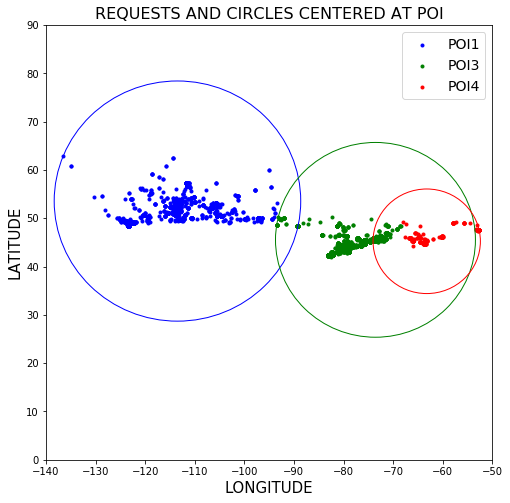

In [28]:
from matplotlib import pyplot as plt


plt.figure(figsize=(8,8))
ax = plt.gca()

plt.scatter(df_DataSample[df_DataSample.Nearest_POIID == 'POI1'].Longitude,
df_DataSample[df_DataSample.Nearest_POIID == 'POI1'].Latitude,
           color = 'b', marker = '.', label='POI1')

plt.scatter(df_DataSample[df_DataSample.Nearest_POIID == 'POI3'].Longitude,
df_DataSample[df_DataSample.Nearest_POIID == 'POI3'].Latitude,
           color = 'g', marker = '.', label='POI3')

plt.scatter(df_DataSample[df_DataSample.Nearest_POIID == 'POI4'].Longitude,
df_DataSample[df_DataSample.Nearest_POIID == 'POI4'].Latitude,
           color = 'r', marker = '.', label='POI4')

plt.ylim((0,90))
plt.xlim((-140,-50))

circle0 = plt.Circle(
( df_POIList[df_POIList.POIID == 'POI1'].Longitude, 
  df_POIList[df_POIList.POIID == 'POI1'].Latitude ), 
  df_POIList[df_POIList.POIID == 'POI1'].Radius ,
          color = 'b', fill = False )
ax.add_artist(circle0)

circle1 = plt.Circle(
( df_POIList[df_POIList.POIID == 'POI3'].Longitude, 
  df_POIList[df_POIList.POIID == 'POI3'].Latitude ), 
  df_POIList[df_POIList.POIID == 'POI3'].Radius ,
          color = 'g', fill = False )
ax.add_artist(circle1)

circle2 = plt.Circle(
( df_POIList[df_POIList.POIID == 'POI4'].Longitude, 
  df_POIList[df_POIList.POIID == 'POI4'].Latitude ), 
  df_POIList[df_POIList.POIID == 'POI4'].Radius ,
          color = 'r', fill = False )
ax.add_artist(circle2)


plt.xlabel('LONGITUDE', fontsize =15)
plt.ylabel('LATITUDE', fontsize =15)
plt.legend(fontsize = 14)
plt.title('REQUESTS AND CIRCLES CENTERED AT POI', fontsize =16)

plt.show()

We see that the plot above displays the requests that came from different parts of Canada. Overall, the coverage by dots implicitly reproduces the plane map of Canada. POI3 was likely to receive the requests that came from Ontario, while POI1 from British Columbia and Prairie provinces. POI4 was most likely responsible for requests from Quebec and Atlantic provinces.
We also see from below that the number of requests related to POI4 is much smaller than those related to POI1 and POI3. This issue, coupled with the differences in corresponding areas of responsibility, leads to the fact that the densities vary significantly among POI's.

In [29]:
print('The number of requests related to POI1 is:', 
      len(df_DataSample.Distance[df_DataSample.Nearest_POIID == df_POIList.POIID[0]]))
      
print('The number of requests related to POI3 is:', 
      len(df_DataSample.Distance[df_DataSample.Nearest_POIID == df_POIList.POIID[1]]))
      
print('The number of requests related to POI4 is:', 
      len(df_DataSample.Distance[df_DataSample.Nearest_POIID == df_POIList.POIID[2]]))

The number of requests related to POI1 is: 9698
The number of requests related to POI3 is: 9817
The number of requests related to POI4 is: 462


## Model: Part 1

Let's compute the mean of the density, averaged over all three POI, as well as the corresponding standard deviation. 

In [30]:
dens_mean = np.mean(df_POIList.Density)
dens_std = np.std(df_POIList.Density)

print('The mean of the Density is:', dens_mean)
print('The standard deviation of the Density is:', dens_std)

The mean of the Density is: 4.648731708575639
The standard deviation of the Density is: 2.639184424055503


We can consider the following mathematical model. The unit of area corresponds to the one degree longitude by one degree longitude square. We break the whole area of interest into unit squares and count the number of requests that came from each square. We first create the new data frame df_Densities with four columns: latitude of the center of a square, longitude of the center of a square, numbers of requests that came from that square and the nearest POI.

In [31]:
df_Densities = pd.DataFrame()

lat_cent = []
lon_cent = []
num_req = []
near_poi = []

m = int(max_lon - min_lon)
n = int(max_lat - min_lat)
del_lon = (max_lon - min_lon)/m
del_lat = (max_lat - min_lat)/n

 
for i in range(m):
    for j in range(n):
        lon_cent.append(min_lon +(i+0.5)*del_lon)
        lat_cent.append(min_lat +(j+0.5)*del_lat)
        
        mask = (min_lon +i*del_lon <= df_DataSample.Longitude) & \
            (df_DataSample.Longitude < min_lon +(i+1)*del_lon) & \
            (min_lat +j*del_lat <= df_DataSample.Latitude) & \
            (df_DataSample.Latitude < min_lat +(j+1)*del_lat)
        
        num_req.append(len(df_DataSample[mask].index)) 
        
        auxlist= []
        for l in list(df_POIList.index):
            auxlist.append(euclidean2D(min_lat +(j+0.5)*del_lat, df_POIList.Latitude[l],
                      min_lon +(i+0.5)*del_lon, df_POIList.Longitude[l]))
        k = np.argmin(auxlist)
        near_poi.append(df_POIList.POIID[k])
   

df_Densities['Lat_centers'] = lat_cent
df_Densities['Lon_centers'] = lon_cent
df_Densities['Req_number'] = num_req
df_Densities['Nearest_POIID'] = near_poi

In [32]:
df_Densities.Req_number.unique()

array([   0,    2,    1,   13,   33,    9,  587,   16,   34,    3,    5,
         26,   30,    6,   27,    4,   36,    7,   78,   18, 3815,  326,
       1169, 1638,   93,   15,  164,   12,  224,   19,    8,   10,  568,
         21,  107,  143,  108,  177,   24,  101,  100,  236,   23,   59,
         38,   14,  716,   42,   41,   86, 5304,  304,   44,  124,   82,
         28,  154,   51,  590,   57, 1020,   22,   11,  128,   69,   65,
         73,  105,   37], dtype=int64)

Let's count how many times one can encounter the above given values for the numbers of requests per square. We see that the overwhelming majority of squares do not have any requests coming from them. 1,2,3,5 and 4 requests seem to be next most-common numbers. 

In [33]:
from collections import Counter

print(Counter(df_Densities.Req_number.values).most_common(21))

[(0, 1450), (1, 42), (2, 36), (3, 15), (5, 13), (4, 8), (9, 7), (6, 7), (13, 4), (16, 4), (7, 4), (10, 4), (36, 3), (26, 2), (18, 2), (15, 2), (12, 2), (8, 2), (38, 2), (14, 2), (33, 1)]


We now consider the mapping of the densities (the numbers of requests per unit square) onto the scale from -10 to 10. The mapping function will be created as follows: 0 requests correspond to -10, 1 request corresponds to -8, 2 yo -6, 3 to -4, 4 to -2, 5 (near average value) to 0, 6,7 to 2, 8,9 requests to 4, 10,11 to 6, 12,13 to 8, while 14 requests or more to 10. The new column with scaled density will be added to the dataframe.

In [34]:
def map_func(k):
    if k == 0: return -10
    elif k == 1: return -8
    elif k == 2: return -6
    elif k == 3: return -4
    elif k == 4: return -2
    elif k == 5: return 0
    elif (k == 6)| (k == 7): return 2
    elif (k == 8)| (k == 9): return 4
    elif (k == 10)| (k == 11): return 6
    elif (k == 12)| (k == 13): return 8
    else: return 10
    
df_Densities['Scaled_density'] = df_Densities.Req_number.map(map_func)

In [35]:
df_Densities.head(20)

,Lat_centers,Lon_centers,Req_number,Nearest_POIID,Scaled_density
0,42.573332,-136.034251,0,POI1,-10
1,43.611998,-136.034251,0,POI1,-10
2,44.650663,-136.034251,0,POI1,-10
3,45.689328,-136.034251,0,POI1,-10
4,46.727992,-136.034251,0,POI1,-10
5,47.766658,-136.034251,0,POI1,-10
6,48.805323,-136.034251,0,POI1,-10
7,49.843988,-136.034251,0,POI1,-10
8,50.882653,-136.034251,0,POI1,-10
9,51.921318,-136.034251,0,POI1,-10


Finally, we will plot the results using the scatter plot using the variable marker sizes. The unit areas that have greater than average scaled density are denoted with circles of blue green and red color, while those with smaller than average scaled density are represented with the lighter shadows of the abovementined colors

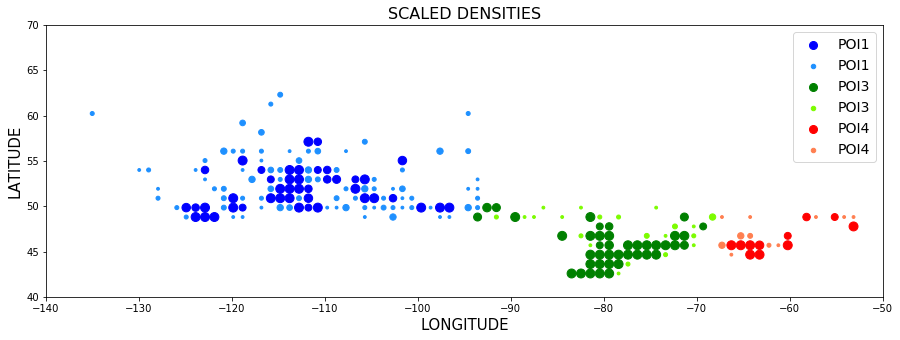

In [36]:
plt.figure(figsize=(15,5))

mask1a = (df_Densities.Nearest_POIID == 'POI1') & (df_Densities.Scaled_density >0)
mask1b = (df_Densities.Nearest_POIID == 'POI1') & (df_Densities.Scaled_density <=0)

mask2a = (df_Densities.Nearest_POIID == 'POI3') & (df_Densities.Scaled_density >0)
mask2b = (df_Densities.Nearest_POIID == 'POI3') & (df_Densities.Scaled_density <=0)

mask3a = (df_Densities.Nearest_POIID == 'POI4') & (df_Densities.Scaled_density >0)
mask3b = (df_Densities.Nearest_POIID == 'POI4') & (df_Densities.Scaled_density <=0)

plt.scatter(df_Densities[mask1a].Lon_centers.values, df_Densities[mask1a].Lat_centers.values,
           color = 'b', marker = 'o',s = 4*(df_Densities[mask1a].Scaled_density.values+10),
           label='POI1')

plt.scatter(df_Densities[mask1b].Lon_centers.values, df_Densities[mask1b].Lat_centers.values,
           color = 'dodgerblue', marker = 'o',s = 4*(df_Densities[mask1b].Scaled_density.values+10),
           label='POI1')

plt.scatter(df_Densities[mask2a].Lon_centers.values, df_Densities[mask2a].Lat_centers.values,
           color = 'g', marker = 'o',s = 4*(df_Densities[mask2a].Scaled_density.values+10),
           label='POI3')

plt.scatter(df_Densities[mask2b].Lon_centers.values, df_Densities[mask2b].Lat_centers.values,
           color = 'lawngreen', marker = 'o',s = 4*(df_Densities[mask2b].Scaled_density.values+10),
           label='POI3')


plt.scatter(df_Densities[mask3a].Lon_centers.values, df_Densities[mask3a].Lat_centers.values,
           color = 'r', marker = 'o',s = 4*(df_Densities[mask3a].Scaled_density.values+10),
           label='POI4')

plt.scatter(df_Densities[mask3b].Lon_centers.values, df_Densities[mask3b].Lat_centers.values,
           color = 'coral', marker = 'o',s = 4*(df_Densities[mask3b].Scaled_density.values+10),
           label='POI4')

plt.ylim((40,70))
plt.xlim((-140,-50))

plt.xlabel('LONGITUDE', fontsize =15)
plt.ylabel('LATITUDE', fontsize =15)
plt.legend(fontsize = 14, loc =1)
plt.title('SCALED DENSITIES', fontsize =16)

plt.show()

We see that the highest requests densities came the densely populated areas around large provincial cities as well as Greater Toronto Area.

## Model: Part 2

In this section, we perform some statistical tests with respect to the Distances in the  df_DataSample.Distance column. We first determine whether the Distances for each POI obey the normal distributions with the calculated mean and standard deviation. We will use the normaltest from scipy.stats module. The null-hypothesis states that data obey normal distribution. Running the tests leads to extremely small p_values indicating that the data in all three 'Distance' datasets do not obey normal distribution.

In [37]:
from scipy import stats

_, p1 = stats.normaltest(df_DataSample.Distance[df_DataSample.Nearest_POIID == 'POI1'].values)
_, p3 = stats.normaltest(df_DataSample.Distance[df_DataSample.Nearest_POIID == 'POI3'].values)
_, p4 = stats.normaltest(df_DataSample.Distance[df_DataSample.Nearest_POIID == 'POI4'].values)
  
print('p-value for null-hypothesis that Distances around POI1 obey normal distribution:',p1)
print('p-value for null-hypothesis that Distances around POI3 obey normal distribution:',p3)
print('p-value for null-hypothesis that Distances around POI4 obey normal distribution:',p4)

p-value for null-hypothesis that Distances around POI1 obey normal distribution: 0.0
p-value for null-hypothesis that Distances around POI3 obey normal distribution: 2.30122848699e-286
p-value for null-hypothesis that Distances around POI4 obey normal distribution: 7.28060770963e-36


We can ask a question about a possible form of the distributions of distances. The histogram plots below show that all three distributions for distances from POI are highly non-uniform. Large values are concentrated around certain distances (or in reality certain locations), so it is difficult to think about any well-known texbook continuos distributions the distances can obey. 

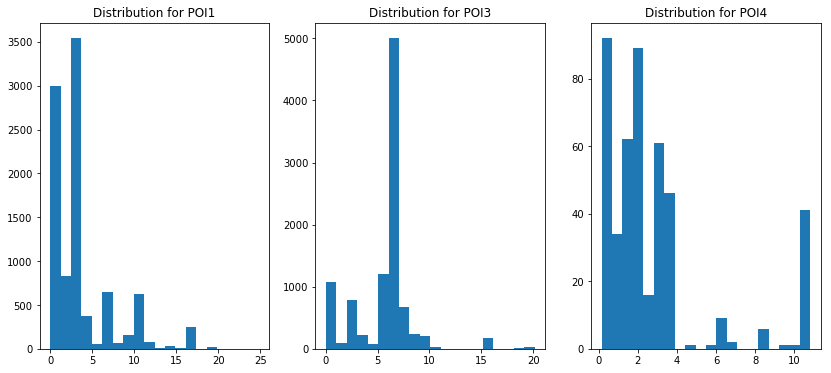

In [38]:
fig, ax = plt.subplots(1, 3, tight_layout=False, figsize=(14,6))

ax[0].hist(df_DataSample.Distance[df_DataSample.Nearest_POIID == 'POI1'].values, bins=20)
ax[1].hist(df_DataSample.Distance[df_DataSample.Nearest_POIID == 'POI3'].values, bins=20)
ax[2].hist(df_DataSample.Distance[df_DataSample.Nearest_POIID == 'POI4'].values, bins=20)

ax[0].set_title('Distribution for POI1')
ax[1].set_title('Distribution for POI3')
ax[2].set_title('Distribution for POI4')

plt.show()